In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
import seq2seq_model
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt


2023-05-03 18:07:45.197110: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('Data/4105819v2474763.csv', index_col=0)
df

,lpt odds,r1 spread,r1 pup,r2 spread,r2 pup,r1_sets_to_win,r2_sets_to_win,enhanced_markov
2018-07-11 16:36:42,0.582314,0.005831,0.076386,0.016807,0.002012,3.0,3.0,0.507162
2018-07-11 16:36:44,0.582350,0.005831,0.076386,0.016807,0.002012,3.0,3.0,0.507162
2018-07-11 16:36:46,0.582387,0.005831,0.074565,0.024288,0.002396,3.0,3.0,0.507162
2018-07-11 16:36:48,0.582423,0.005831,0.072341,0.029768,0.003003,3.0,3.0,0.507162
2018-07-11 16:36:50,0.582460,0.005831,0.070063,0.032151,0.003397,3.0,3.0,0.507162
...,...,...,...,...,...,...,...,...
2018-07-11 19:32:56,0.000000,1.595506,0.206208,0.048309,0.725523,2.0,0.0,0.000000
2018-07-11 19:32:58,0.000000,1.595506,0.206208,0.048309,0.725523,2.0,0.0,0.000000
2018-07-11 19:33:00,0.000000,1.595506,0.206208,0.048309,0.725523,2.0,0.0,0.000000
2018-07-11 19:33:02,0.000000,1.595506,0.206208,0.048309,0.725523,2.0,0.0,0.000000


In [3]:
data = df.to_numpy()
data

array([[0.58231363, 0.0058309 , 0.07638615, ..., 3.        , 3.        ,
        0.50716188],
       [0.58235018, 0.0058309 , 0.07638615, ..., 3.        , 3.        ,
        0.50716188],
       [0.58238673, 0.0058309 , 0.07456494, ..., 3.        , 3.        ,
        0.50716188],
       ...,
       [0.        , 1.59550562, 0.20620843, ..., 2.        , 0.        ,
        0.        ],
       [0.        , 1.59550562, 0.20620843, ..., 2.        , 0.        ,
        0.        ],
       [0.        , 1.59550562, 0.20620843, ..., 2.        , 0.        ,
        0.        ]])

In [4]:
train, test = train_test_split(data, test_size=0.2, shuffle=False)

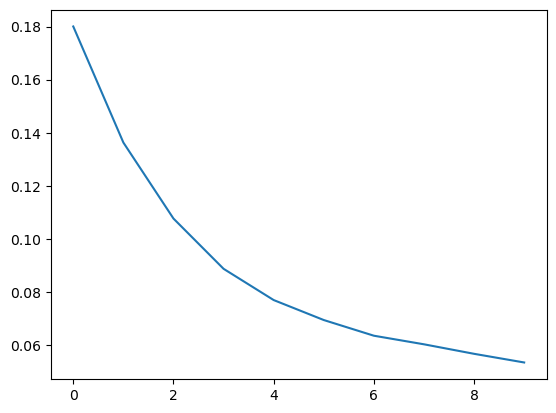

In [5]:
hist = pd.read_csv('train_hist.csv')
plt.plot(hist['mae'])

In [6]:
model = load_model("seq2seq_model")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               43600     
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 repeat_vector (RepeatVector  (None, 90, 100)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 90, 100)           80400     
                                                                 
 time_distributed (TimeDistr  (None, 90, 50)           5050      
 ibuted)                                                         
                                                        

(1045980, 8)
(270, 8)
1/1 [==============================] - 0s 370ms/step
[0.45554945 0.41929138 0.38943258 0.36307114 0.34126174 0.32428837
 0.31102824 0.3007803  0.29312825 0.2875952  0.28372055 0.28110477
 0.27942133 0.2784118  0.2778768  0.27766636 0.27766994 0.27780774
 0.2780235  0.27827832 0.2785465  0.2788112  0.2790623  0.27929398
 0.2795036  0.2796906  0.27985552 0.2799997  0.28012493 0.28023314
 0.280326   0.28040555 0.2804734  0.28053123 0.28058028 0.2806219
 0.2806571  0.2806868  0.28071192 0.28073293 0.28075078 0.2807657
 0.28077823 0.2807887  0.2807975  0.28080484 0.28081098 0.2808161
 0.2808204  0.280824   0.28082693 0.28082943 0.28083137 0.28083307
 0.2808345  0.28083563 0.28083652 0.28083733 0.2808379  0.28083843
 0.28083876 0.2808391  0.28083935 0.2808396  0.28083968 0.2808398
 0.28083992 0.28083995 0.28083998 0.28083998 0.28083998 0.28083995
 0.28083995 0.2808399  0.28083992 0.28083983 0.28083983 0.2808398
 0.28083974 0.28083974 0.2808396  0.2808396  0.2808396  0.2

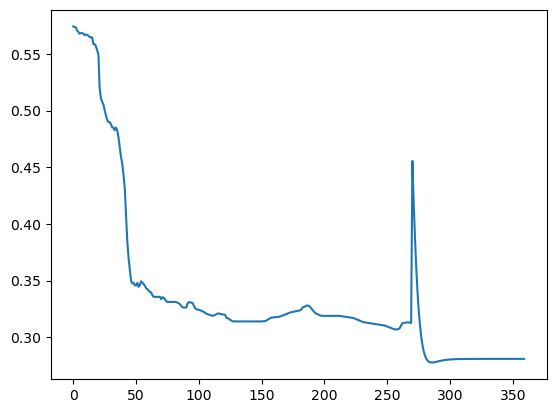

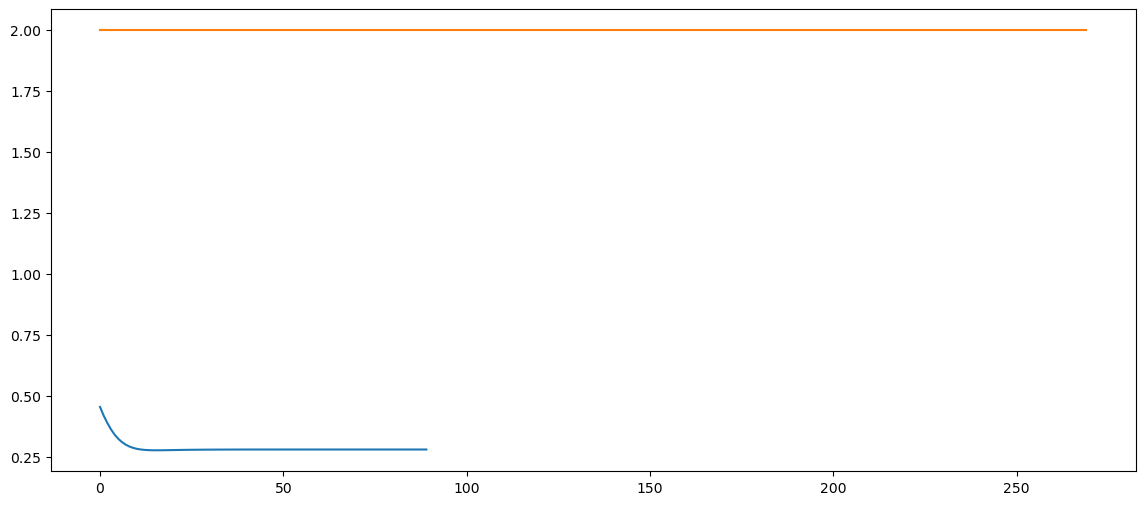

In [7]:
test_x, test_y = seq2seq_model.truncate_data(train, 270, 90, features=range(1))
yhat = seq2seq_model.make_forecast(model, test_x, features=range(8))
print(yhat[:, 0])
plt.figure(figsize=(14,6))
plt.plot(yhat[:, 0])
plt.plot(test_x[-1, :, 5])
# y = np.concatenate((test_x[-1, :, 0], yhat[:, 0])

In [7]:
print(predictions.shape)
print(test_out.shape)
print(test_in.shape)
print(len(data))
print(3459 + 3459)
mae = mae(test_out, predictions)
mse = mae**2
rmse = np.sqrt(mse)
print("The mae for this prediction is: " + str(mae))
print("The mse for this prediction is: " + str(mse))
print("The rmse for this prediction is: " + str(rmse))

(1415, 105, 5)
(1415, 105, 5)
(1415, 525, 5)
10220
6918


ValueError: Found array with dim 3. None expected <= 2.

In [8]:
validation = df[math.ceil( len(df) * 0.8 ):]
df_pred = pd.DataFrame(predictions, columns = ['pred odds', 'pred r1 spread', 'pred r1 pup', 'pred r2 spread', 'pred r2 pup'])
df_pred.index = validation.index
validation = pd.concat([validation,df_pred],axis=1)
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Time')
plt.ylabel('Implied Probabilities')
plt.plot(validation[['avg','pred odds']])
plt.legend(['Measured values', 'Predictions'], loc='lower right')
plt.show()

ValueError: Must pass 2-d input. shape=(3459, 105, 5)